## Finding themes, keywords phrases from movie descriptions

#### Installing the necessary packages

In [1]:
#pip install WordCloud
#pip install nltk

#import nltk

#nltk.download('stopwords')
#pip install gensim
#pip install TextBlob

#### Importing the data

In [2]:
import pandas as pd

data=pd.read_csv("fil_data_movies_lessthan10k_replaced.csv")

In [3]:
data.columns

Index(['id', 'title', 'vote_average', 'vote_count', 'release_date', 'revenue',
       'runtime', 'adult', 'backdrop_path', 'budget', 'homepage', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'tagline', 'genres', 'production_companies',
       'production_countries', 'spoken_languages'],
      dtype='object')

In [4]:
data = data[['id', 'title', 'vote_average', 'vote_count', 'overview']]
data.columns

Index(['id', 'title', 'vote_average', 'vote_count', 'overview'], dtype='object')

In [5]:
data['overview']

0        Cobb, a skilled thief who commits corporate es...
1        The adventures of a group of explorers who mak...
2        Batman raises the stakes in his war on crime. ...
3        In the 22nd century, a paraplegic Marine is di...
4        When an unexpected enemy emerges and threatens...
                               ...                        
26224    John Shepherd spent 30 years trying to contact...
26225    A crowd-sourced documentary with clips filmed ...
26226    In late eighties, in Ceausescu's Romania, a bl...
26227    Carrying on the Prom Night tradition, this fil...
26228    When Lacey takes a rare break from work for he...
Name: overview, Length: 26229, dtype: object

Remove all 'NA' values from 'overview' column, necessary for modelling later.

In [6]:
print(data.shape)
data= data.dropna(subset=['overview'])
print(data.shape)

(26229, 5)
(26176, 5)


#### Preprocess the data for finding the most popular words used in movie descriptions

Define a rating threshold for comparing all movies with higher rated movies. <br>
Remove all of the english stopwords. <br>
Convert all text to lowercase. <br>
Remove stopwords, punctuation, and apostrophes. <br>
Split the text into individual words (tokenization). <br>

In [7]:
from collections import Counter
import matplotlib.pyplot as plt
import nltk

def preprocess_and_get_word_frequencies_top_ratings(quantile):
    df = pd.read_csv("fil_data_movies_lessthan10k_replaced.csv", usecols=['title','overview', 'vote_average'])
    rating_threshold = df['vote_average'].quantile(quantile)
    df_top_ratings = df[df['vote_average'] >= rating_threshold]
    
    stopwords = nltk.corpus.stopwords.words('english')
    RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
    words = (df_top_ratings.overview
               .str.lower()
               .replace([r'\|', RE_stopwords, r'\.', r',', r'\''], [' ', '', '', '', ''], regex=True)
               .str.cat(sep=' ')
               .split()
    )
    rslt = pd.DataFrame(Counter(words).most_common(),
                        columns=['Word', 'Frequency']).set_index('Word')
    return rslt

Identify the most frequently occurring words in the descriptions of the top 1%, 5%, and 10% highest-rated movies, as well as in the descriptions of all movies.

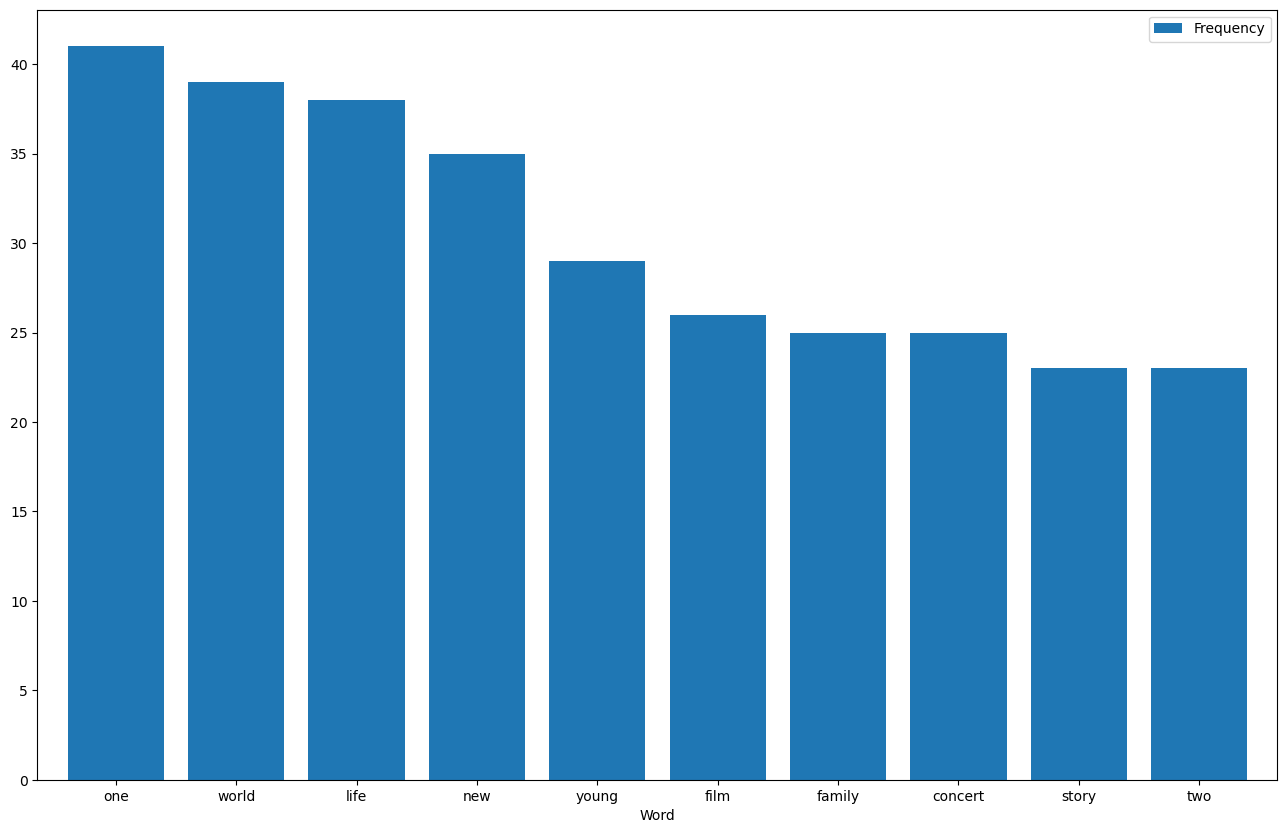

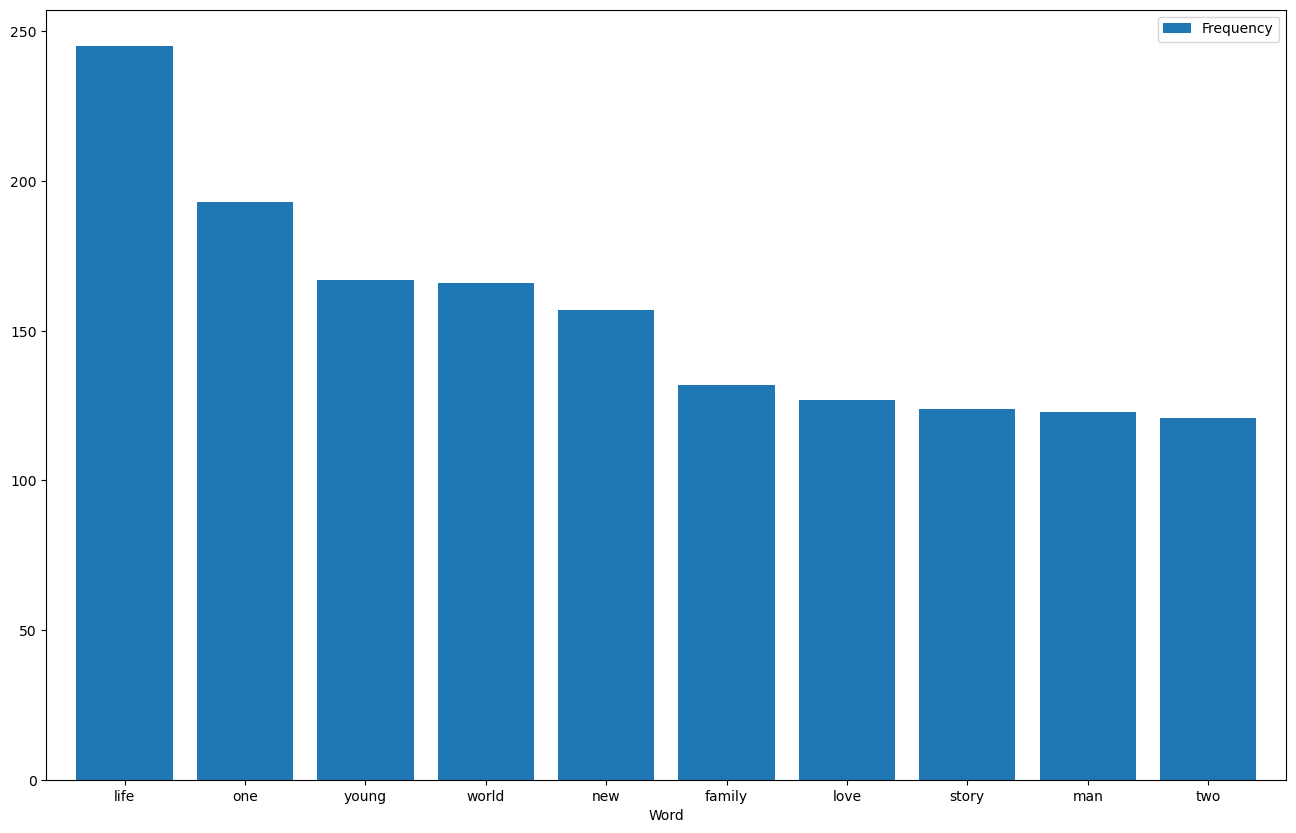

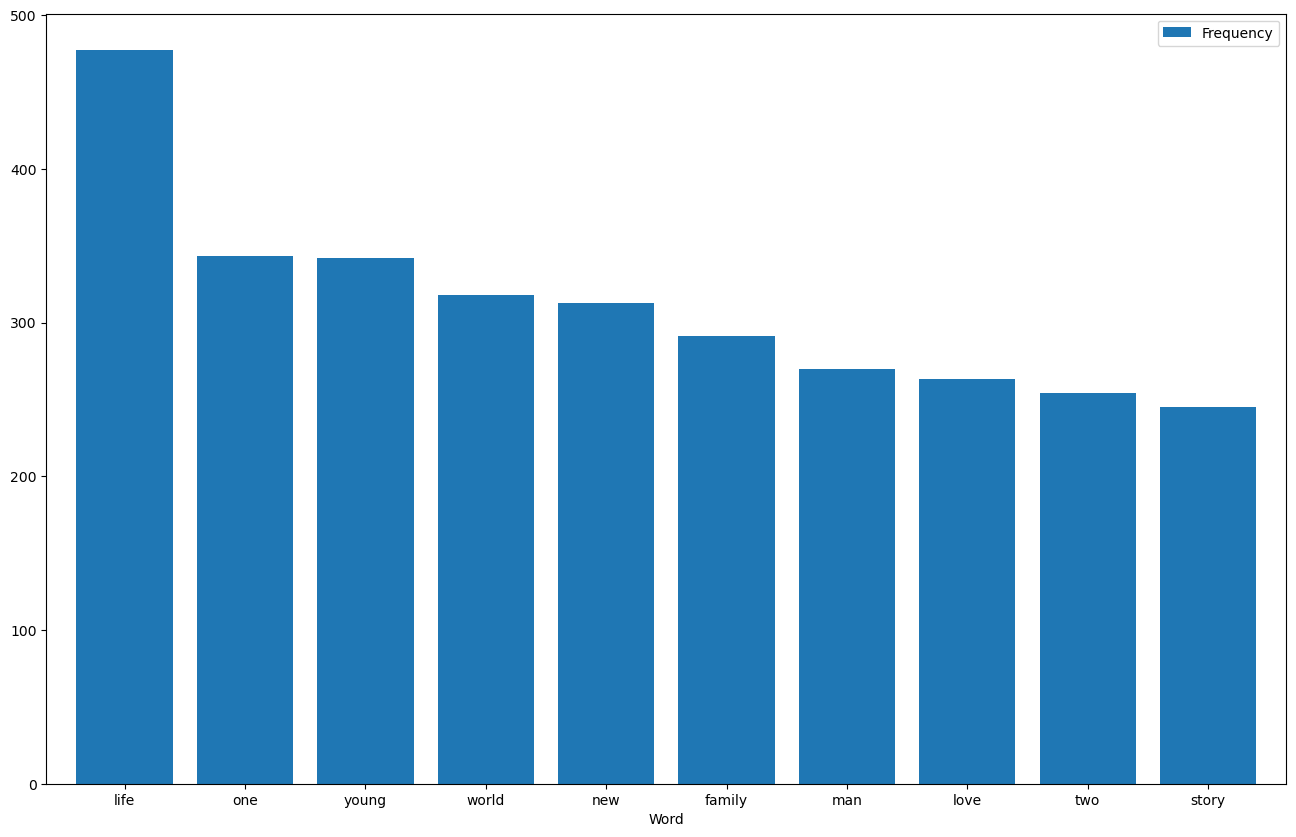

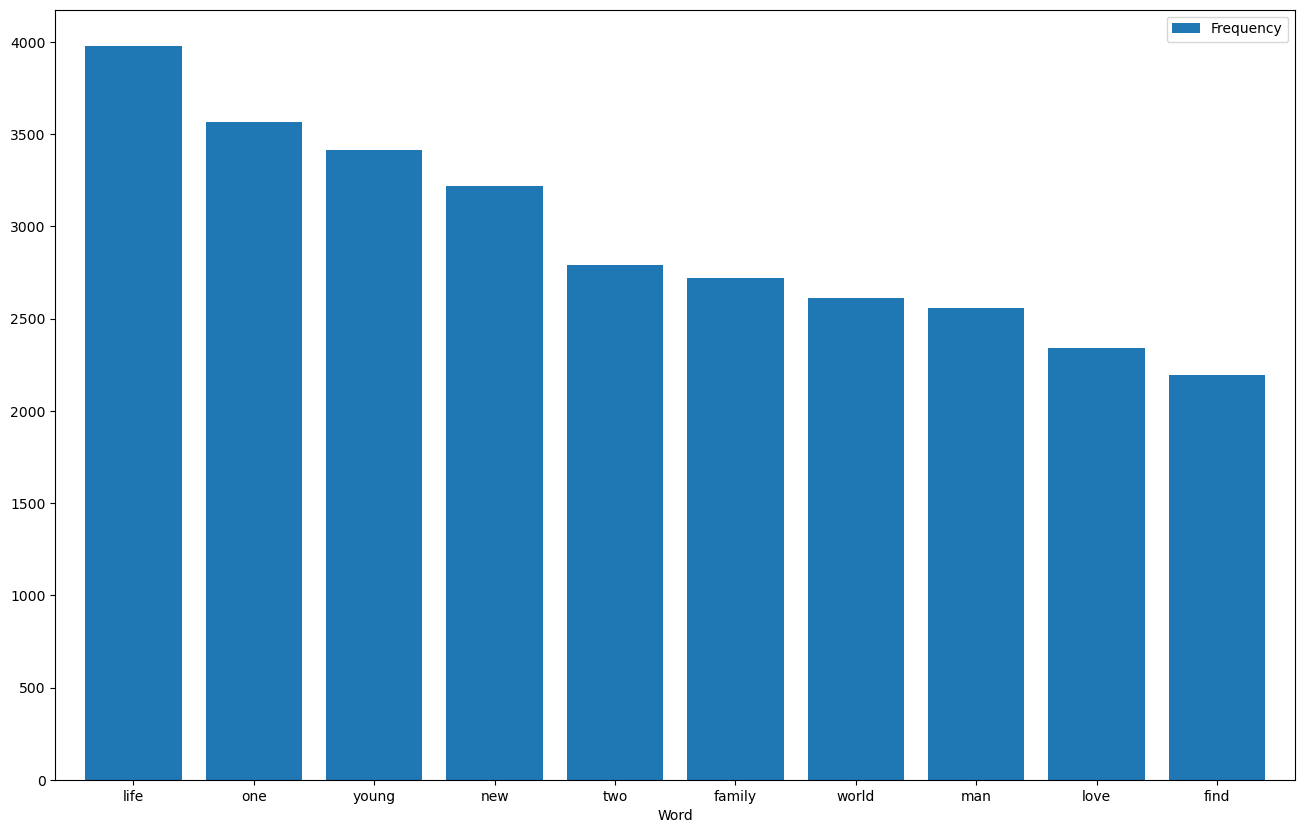

In [8]:
def plot_top_words(rslt, top_N):
    top_words = rslt.head(top_N)
    top_words.plot.bar(rot=0, figsize=(16,10), width=0.8)
    plt.show()

rslt_top_ratings = preprocess_and_get_word_frequencies_top_ratings(quantile=0.99)
plot_top_words(rslt_top_ratings, 10)
rslt_top_ratings = preprocess_and_get_word_frequencies_top_ratings(quantile=0.95)
plot_top_words(rslt_top_ratings, 10)
rslt_top_ratings = preprocess_and_get_word_frequencies_top_ratings(quantile=0.9)
plot_top_words(rslt_top_ratings, 10)
rslt_top_ratings = preprocess_and_get_word_frequencies_top_ratings(quantile=0.0)
plot_top_words(rslt_top_ratings, 10)

Plot the 10% highest movies and all of the movies on a wordcloud

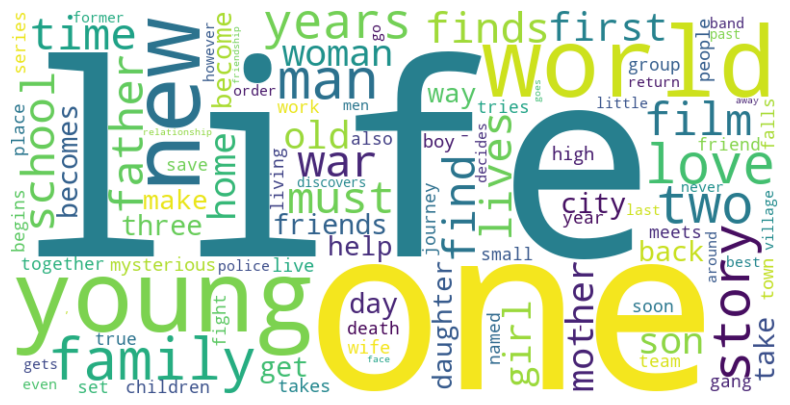

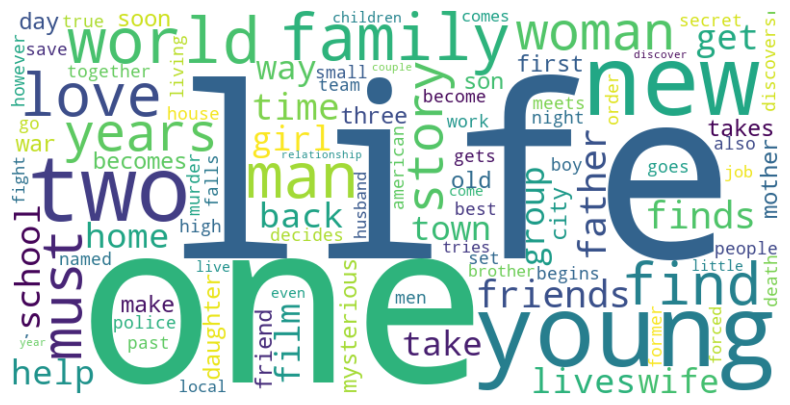

In [9]:
from wordcloud import WordCloud

def create_word_cloud(rslt):
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(rslt['Frequency'])
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
 
rslt_top_ratings = preprocess_and_get_word_frequencies_top_ratings(quantile=0.9)
create_word_cloud(rslt_top_ratings)
rslt_top_ratings = preprocess_and_get_word_frequencies_top_ratings(quantile=0.0)
create_word_cloud(rslt_top_ratings)

Same thing as above, just with phrases.

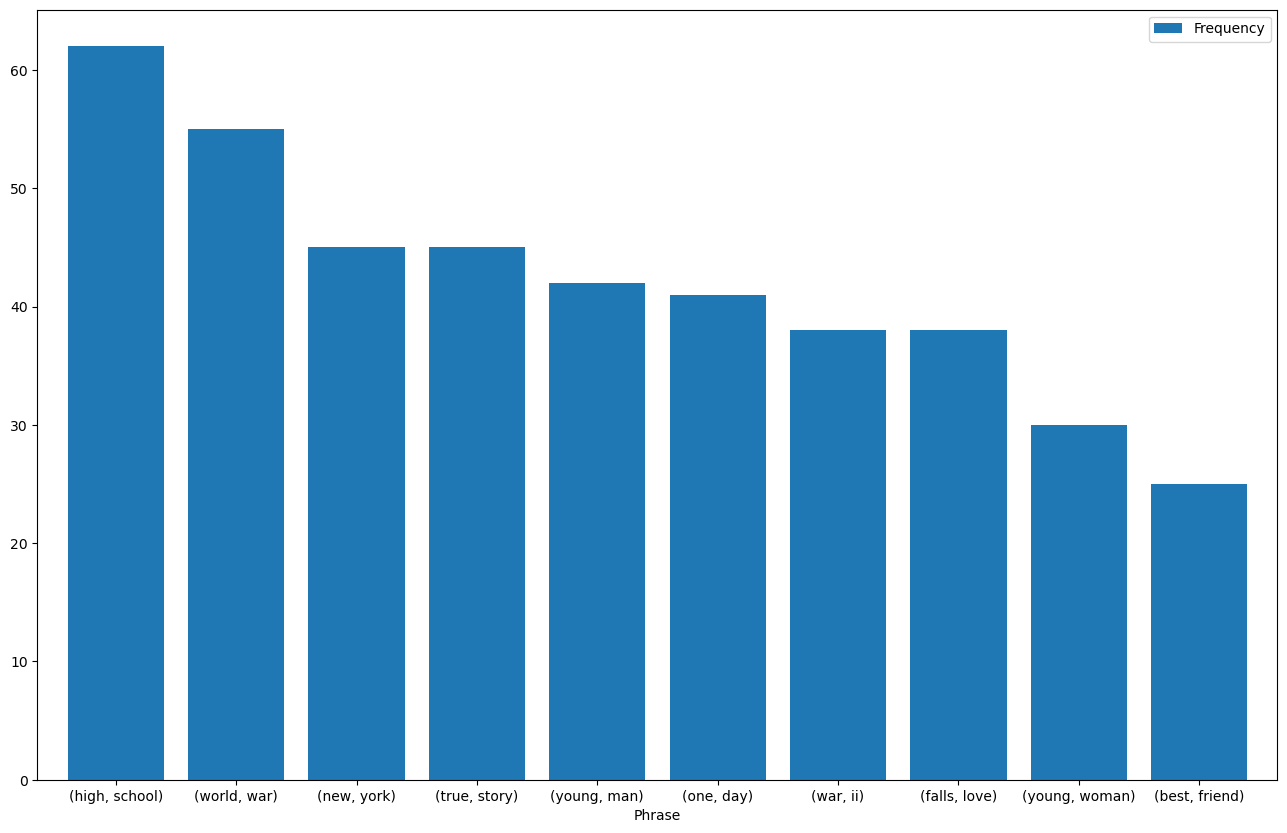

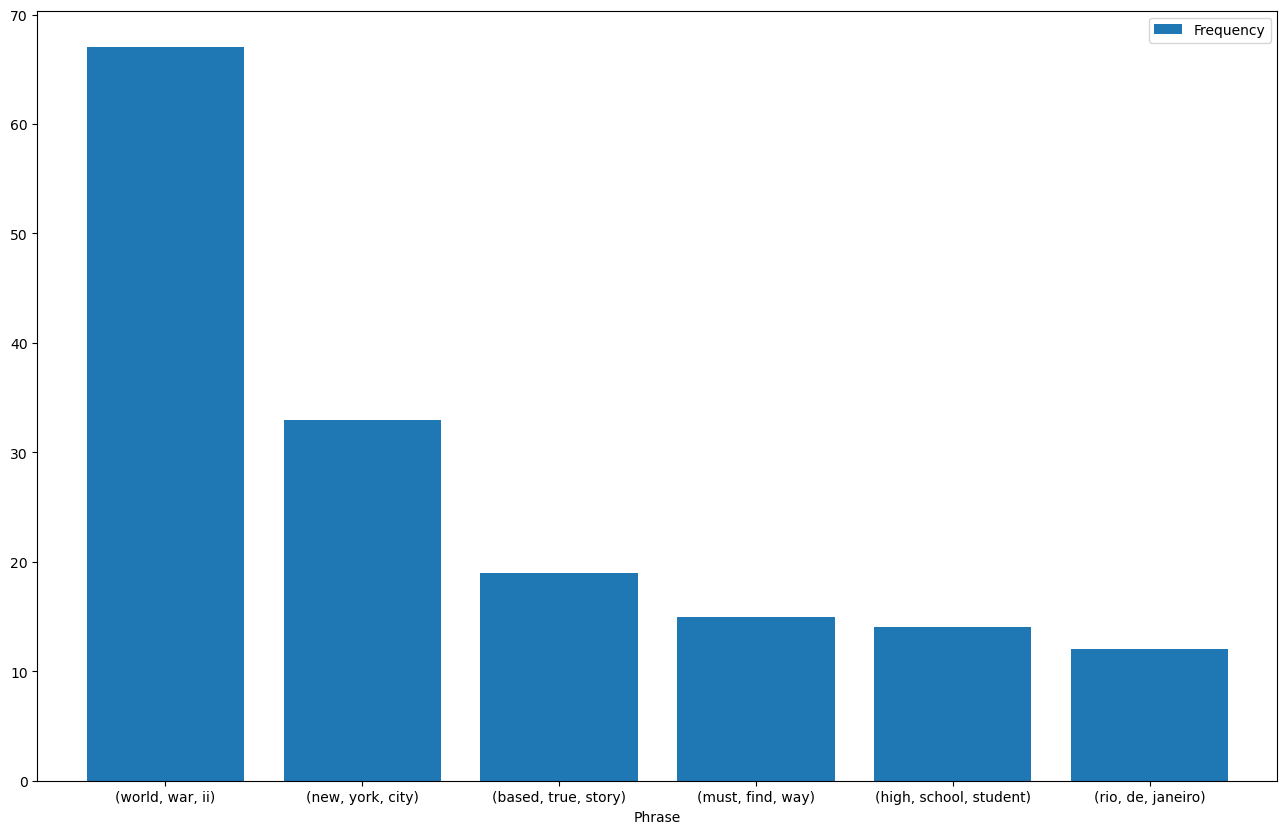

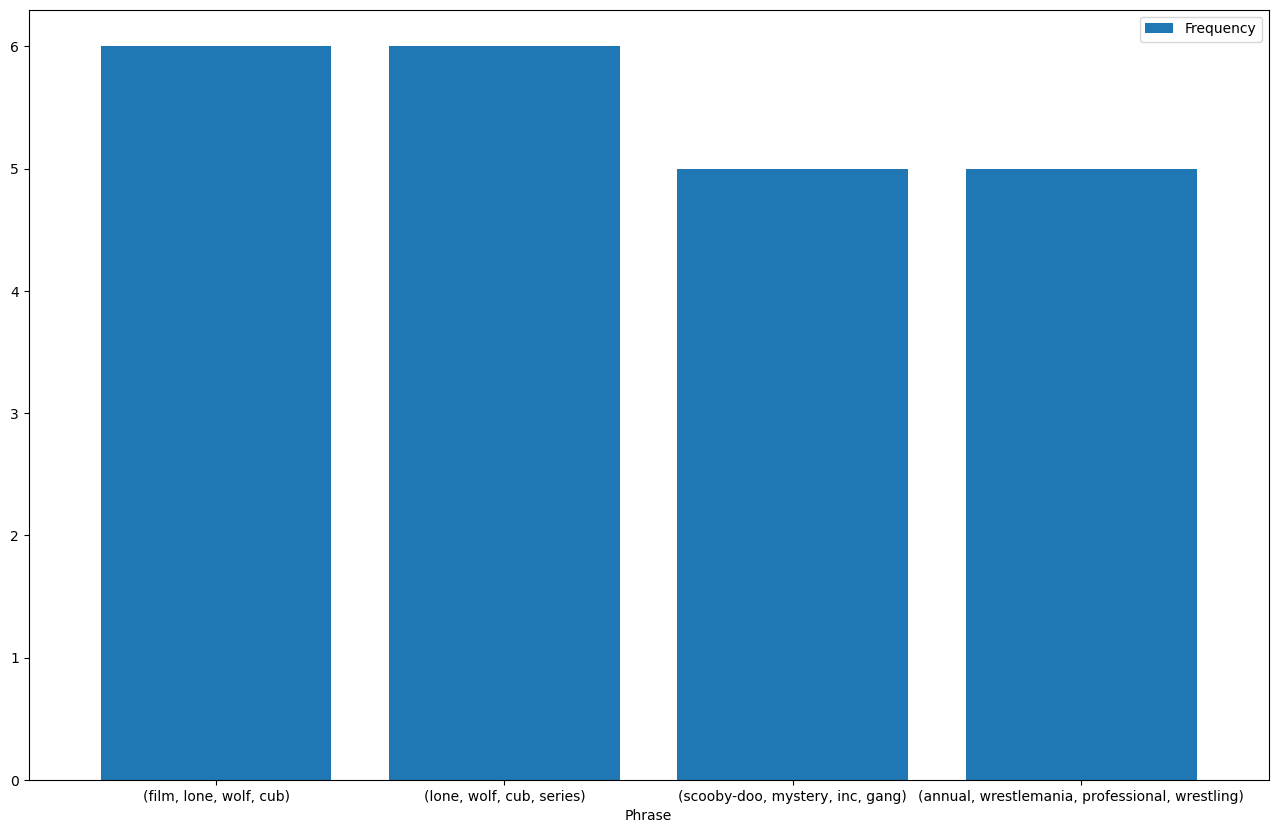

In [10]:
from nltk import ngrams

def preprocess_and_get_phrase_frequencies_top_ratings(quantile=0.9, ngrams_counter=2):
    df = pd.read_csv("fil_data_movies_lessthan10k_replaced.csv", usecols=['title','overview', 'vote_average'])
    rating_threshold = df['vote_average'].quantile(quantile)
    df_top_ratings = df[df['vote_average'] >= rating_threshold]
    
    stopwords = nltk.corpus.stopwords.words('english')
    RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
    words = (df_top_ratings.overview
               .str.lower()
               .replace([r'\|', RE_stopwords, r'\.', r',', r'\''], [' ', '', '', '', ''], regex=True)
               .str.cat(sep=' ')
               .split()
    )
    
    ngrams_words = ngrams(words, ngrams_counter)
    freq_dist = Counter(ngrams_words)
    rslt = pd.DataFrame(freq_dist.most_common(), columns=['Phrase', 'Frequency']).set_index('Phrase')
    return rslt

rslt_top_ratings_phrases = preprocess_and_get_phrase_frequencies_top_ratings(quantile=0.9, ngrams_counter=2)
plot_top_words(rslt_top_ratings_phrases, 10)

rslt_top_ratings_phrases = preprocess_and_get_phrase_frequencies_top_ratings(quantile=0.8, ngrams_counter=3)
plot_top_words(rslt_top_ratings_phrases, 6)

rslt_top_ratings_phrases = preprocess_and_get_phrase_frequencies_top_ratings(quantile=0.75, ngrams_counter=4)
plot_top_words(rslt_top_ratings_phrases, 4)

##### Attempt using LDA to find common themes throughout the movies, didn't give us many insights in this dataset.

In [11]:
from gensim import corpora, models
from nltk import ngrams
from collections import Counter

def preprocess_and_get_lda_topics(quantile, ngrams_counter):
    df = pd.read_csv("fil_data_movies_lessthan10k_replaced.csv", usecols=['title','overview', 'vote_average'])
    rating_threshold = df['vote_average'].quantile(quantile)
    df_top_ratings = df[df['vote_average'] >= rating_threshold]
    
    stopwords = nltk.corpus.stopwords.words('english')
    RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
    words = (df_top_ratings.overview
               .str.lower()
               .replace([r'\|', RE_stopwords, r'\.', r',', r'\''], [' ', '', '', '', ''], regex=True)
               .str.cat(sep=' ')
               .split()
    )

    ngrams_words = [' '.join(ngram) for ngram in ngrams(words, ngrams_counter)]
    dictionary = corpora.Dictionary([ngrams_words])
    corpus = [dictionary.doc2bow(text) for text in [ngrams_words]]
    lda = models.LdaModel(corpus, num_topics=10, id2word=dictionary)
    topics = lda.print_topics(num_words=5)
    for topic in topics:
        print(topic)
    
preprocess_and_get_lda_topics(quantile=0.9, ngrams_counter=1)
preprocess_and_get_lda_topics(quantile=0.0, ngrams_counter=1)

(0, '0.005*"life" + 0.004*"world" + 0.004*"one" + 0.003*"family" + 0.003*"young"')
(1, '0.006*"life" + 0.004*"world" + 0.004*"one" + 0.003*"family" + 0.003*"young"')
(2, '0.005*"life" + 0.004*"one" + 0.003*"young" + 0.003*"world" + 0.003*"man"')
(3, '0.005*"life" + 0.004*"new" + 0.004*"young" + 0.004*"one" + 0.003*"world"')
(4, '0.004*"life" + 0.003*"young" + 0.003*"two" + 0.003*"one" + 0.003*"world"')
(5, '0.004*"life" + 0.004*"new" + 0.004*"man" + 0.003*"two" + 0.003*"one"')
(6, '0.005*"life" + 0.004*"one" + 0.004*"new" + 0.004*"young" + 0.004*"man"')
(7, '0.006*"life" + 0.005*"family" + 0.004*"young" + 0.004*"new" + 0.004*"world"')
(8, '0.006*"life" + 0.005*"one" + 0.004*"world" + 0.003*"young" + 0.003*"new"')
(9, '0.005*"life" + 0.005*"young" + 0.004*"one" + 0.004*"world" + 0.004*"new"')
(0, '0.007*"life" + 0.005*"young" + 0.004*"new" + 0.004*"world" + 0.004*"one"')
(1, '0.006*"life" + 0.004*"one" + 0.004*"young" + 0.004*"man" + 0.004*"family"')
(2, '0.005*"young" + 0.005*"life" + 

#### Find the sentiment values for descriptions using TextBlob

In [12]:
from textblob import TextBlob
data['description'] = data['overview'].apply(str)

def get_sentiment(text):
    blob = TextBlob(text)
    # This returns a value between -1 and 1. Negative value means a negative sentiment, positive value means a positive sentiment.
    return blob.sentiment.polarity

data['sentiment'] = data['description'].apply(get_sentiment)

print(data[['description', 'sentiment']])

                                             description  sentiment
0      Cobb, a skilled thief who commits corporate es...  -0.011111
1      The adventures of a group of explorers who mak...   0.045455
2      Batman raises the stakes in his war on crime. ...   0.025000
3      In the 22nd century, a paraplegic Marine is di...   0.041667
4      When an unexpected enemy emerges and threatens...   0.025000
...                                                  ...        ...
26224  John Shepherd spent 30 years trying to contact...  -0.050000
26225  A crowd-sourced documentary with clips filmed ...   0.000000
26226  In late eighties, in Ceausescu's Romania, a bl...   0.006667
26227  Carrying on the Prom Night tradition, this fil...  -0.021692
26228  When Lacey takes a rare break from work for he...   0.287500

[26176 rows x 2 columns]


##### Plot sentiment values found above

 0.000000    2798
 0.100000     451
 0.250000     369
 0.500000     344
-0.100000     285
             ... 
 0.272222       1
 0.206667       1
 0.138154       1
-0.122727       1
-0.021692       1
Name: sentiment, Length: 7411, dtype: int64
1.0
-1.0


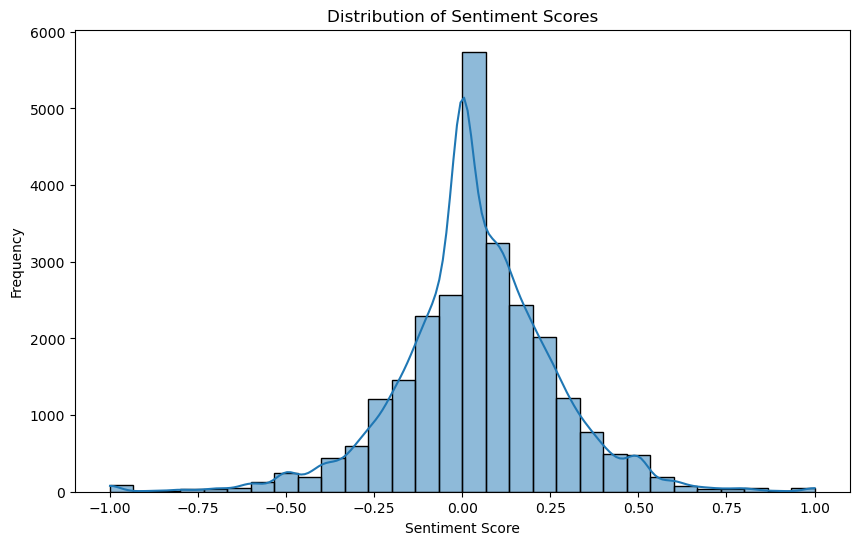

In [13]:
print(data['sentiment'].value_counts())
print(data['sentiment'].max())
print(data['sentiment'].min())

import matplotlib.pyplot as plt
import seaborn as sns
sentiments = data['sentiment']

plt.figure(figsize=(10,6))
sns.histplot(sentiments, bins=30, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

## Training a machine learning model based on movie descriptions

Note: the "original_TMDB_movie_dataset_v11.csv" has to be downloaded from https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies as it is too big to feature on our GitHub page. Using the original dataset isnt necessary, but rather was used for testing whether a dataset 3x times as big as the biggest of our 2 current datasets, would have a real impact on the models used.

In our project we mostly used naive-bayes and support vector machine algorithms to train our models (though other algorithms were tested). For each algorithm we also tried different hyper-parameters for improving our model. For natural language processing we also needed to use a vectorial/numerical representation of text strings. For this we used count vectorizers and TF-IDF vectorizers for each of the different algorithms. Toward the end of the project we also tried Word2Vec and Doc2Vec vectorizers. We also tried adding new description parameters such as most popular words and description lengths.

In [14]:
#datafull=pd.read_csv("original_TMDB_movie_dataset_v11.csv")
'''
datafull=datafull[datafull['vote_count'] >= 10]
print(datafull.shape)
datafull= datafull.dropna(subset=['overview'])
print(datafull.shape)'''

"\ndatafull=datafull[datafull['vote_count'] >= 10]\nprint(datafull.shape)\ndatafull= datafull.dropna(subset=['overview'])\nprint(datafull.shape)"

In [15]:
'''threshold = datafull['vote_average'].mean()
datafull['is_good'] = datafull['vote_average'].apply(lambda x: 1 if x >= threshold else 0)
print(datafull['is_good'].value_counts())'''

"threshold = datafull['vote_average'].mean()\ndatafull['is_good'] = datafull['vote_average'].apply(lambda x: 1 if x >= threshold else 0)\nprint(datafull['is_good'].value_counts())"

#### Define the threshold of a good movie

In [16]:
threshold=6.5
data['is_good'] = data['vote_average'].apply(lambda x: 1 if x >= threshold else 0)

data['is_good'].value_counts()

0    13240
1    12936
Name: is_good, dtype: int64

In [17]:
#data.head(2000)['is_good'].value_counts()
data2=pd.read_csv("fil_data_movies_lessthan10k_removed.csv")

threshold = 6.5
data2['is_good'] = data2['vote_average'].apply(lambda x: 1 if x >= threshold else 0)

data2['is_good'].value_counts()

1    3871
0    3571
Name: is_good, dtype: int64

#### Preprocess the data for machine learning

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from math import sqrt

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'\W', ' ', str(text))
    text = text.lower()
    text = re.sub(r'\s+[a-z]\s+', ' ', text)
    text = re.sub(r'^[a-z]\s+', ' ', text)
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

data['overview'] = data['overview'].apply(preprocess_text)
print(data['overview'][0])
print(data['overview'])
#datafull['overview'] = datafull['overview'].apply(preprocess_text)

cobb skill thief commit corpor espionag infiltr subconsci target offer chanc regain old life payment task consid imposs incept implant anoth person idea target subconsci
0        cobb skill thief commit corpor espionag infilt...
1        adventur group explor make use newli discov wo...
2        batman rais stake war crime help lt jim gordon...
3        22nd centuri parapleg marin dispatch moon pand...
4        unexpect enemi emerg threaten global safeti se...
                               ...                        
26224    john shepherd spent 30 year tri contact extrat...
26225                crowd sourc documentari clip film day
26226    late eighti ceausescu romania black market vh ...
26227    carri prom night tradit film begin back hamilt...
26228    lacey take rare break work friend ava christma...
Name: overview, Length: 26176, dtype: object


#### Use a logistic regression model to predict ratings (with TFIDF and CountVectorizers)

In [19]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

def logistic_reg_classification(data, thresholds, vectorizers, param_grid):
    classifier = LogisticRegression(max_iter=1000)

    for threshold in thresholds:
        data['is_good'] = data['vote_average'].apply(lambda x: 1 if x >= threshold else 0)
        X_train, X_test, y_train, y_test = train_test_split(data['overview'], data['is_good'], test_size=0.2, random_state=1)

        for vectorizer in vectorizers:
            # Convert the movie descriptions into a matrix of features
            X_train_dtm = vectorizer.fit_transform(X_train)
            X_test_dtm = vectorizer.transform(X_test)
            
            #Use gridsearch to find the best hyperparameters
            grid = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
            grid.fit(X_train_dtm, y_train)
            print(f'Threshold: {threshold}, Vectorizer: {vectorizer.__class__.__name__}, Classifier: {classifier.__class__.__name__}, Best parameters: {grid.best_params_}, Best score: {grid.best_score_}')

            # Make predictions on the test set using the best model
            y_pred_class = grid.predict(X_test_dtm)
            accuracy = metrics.accuracy_score(y_test, y_pred_class)
            precision = metrics.precision_score(y_test, y_pred_class)
            recall = metrics.recall_score(y_test, y_pred_class)
            print(f'Test set accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

thresholds = [6.5]
vectorizers = [CountVectorizer(stop_words='english'), TfidfVectorizer(stop_words='english')]
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

logistic_reg_classification(data, thresholds, vectorizers, param_grid)
#thresholds = [6.2]
#logistic_reg_classification(datafull, thresholds, vectorizers, param_grid)

Threshold: 6.5, Vectorizer: CountVectorizer, Classifier: LogisticRegression, Best parameters: {'C': 0.1}, Best score: 0.6166189111747851
Test set accuracy: 0.622803666921314, Precision: 0.6194895591647331, Recall: 0.6178172001542614
Threshold: 6.5, Vectorizer: TfidfVectorizer, Classifier: LogisticRegression, Best parameters: {'C': 1}, Best score: 0.6273638968481375
Test set accuracy: 0.6283422459893048, Precision: 0.6262192742879438, Recall: 0.6189741612032394


#### Since svm takes a long time to run, use only the first 2000 entries, interestingly reducing the entries improves the models accuracy (assuming we do not change the threshold of the movies).

In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics
from sklearn.svm import SVC

def svm_classification(data, thresholds, vectorizers, param_grid):
    classifier = SVC()

    for threshold in thresholds:
        data['is_good'] = data['vote_average'].apply(lambda x: 1 if x >= threshold else 0)
        X_train, X_test, y_train, y_test = train_test_split(data['overview'], data['is_good'], test_size=0.2, random_state=1)

        for vectorizer in vectorizers:
            # Convert the movie descriptions into a matrix of features
            X_train_dtm = vectorizer.fit_transform(X_train)
            X_test_dtm = vectorizer.transform(X_test)
            
            # Use gridsearch to find the best hyperparameters
            grid = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
            grid.fit(X_train_dtm, y_train)
            print(f'Threshold: {threshold}, Vectorizer: {vectorizer.__class__.__name__}, Classifier: {classifier.__class__.__name__}, Best parameters: {grid.best_params_}, Best score: {grid.best_score_}')

            # Make predictions on the test set using the best model
            y_pred_class = grid.predict(X_test_dtm)
            accuracy = metrics.accuracy_score(y_test, y_pred_class)
            precision = metrics.precision_score(y_test, y_pred_class)
            recall = metrics.recall_score(y_test, y_pred_class)
            print(f'Test set accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

thresholds = [7]
vectorizers = [CountVectorizer(stop_words='english'), TfidfVectorizer(stop_words='english')]
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': [1, 0.1, 0.01]}
svm_classification(data.head(2000), thresholds, vectorizers, param_grid)

C:\Users\vexil\AppData\Local\Temp\ipykernel_18672\1114983381.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_good'] = data['vote_average'].apply(lambda x: 1 if x >= threshold else 0)


Threshold: 7, Vectorizer: CountVectorizer, Classifier: SVC, Best parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}, Best score: 0.589375
Test set accuracy: 0.56, Precision: 0.5194174757281553, Recall: 0.5815217391304348
Threshold: 7, Vectorizer: TfidfVectorizer, Classifier: SVC, Best parameters: {'C': 1, 'gamma': 1, 'kernel': 'linear'}, Best score: 0.6050000000000001
Test set accuracy: 0.59, Precision: 0.5485436893203883, Recall: 0.6141304347826086


#### Using a naive-bayes model to predict the ratings (with TFIDF and CountVectorizers)

In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

def naive_bayes_classification(data, thresholds, vectorizers, param_grid):
    classifier = MultinomialNB()

    for threshold in thresholds:
        data['is_good'] = data['vote_average'].apply(lambda x: 1 if x >= threshold else 0)
        X_train, X_test, y_train, y_test = train_test_split(data['overview'], data['is_good'], test_size=0.2, random_state=1)

        for vectorizer in vectorizers:
            # Convert the movie descriptions into a matrix of features
            X_train_dtm = vectorizer.fit_transform(X_train)
            X_test_dtm = vectorizer.transform(X_test)

            # Use gridsearch to find the best hyperparameters
            grid = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
            grid.fit(X_train_dtm, y_train)
            print(f'Threshold: {threshold}, Vectorizer: {vectorizer.__class__.__name__}, Classifier: {classifier.__class__.__name__}, Best parameters: {grid.best_params_}, Best score: {grid.best_score_}')

            # Make predictions on the test set using the best model
            y_pred_class = grid.predict(X_test_dtm)
            accuracy = metrics.accuracy_score(y_test, y_pred_class)
            precision = metrics.precision_score(y_test, y_pred_class)
            recall = metrics.recall_score(y_test, y_pred_class)

            print(f'Test set accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

thresholds = [6.5]
vectorizers = [CountVectorizer(stop_words='english'), TfidfVectorizer(stop_words='english')]
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}
naive_bayes_classification(data, thresholds, vectorizers, param_grid)

Threshold: 6.5, Vectorizer: CountVectorizer, Classifier: MultinomialNB, Best parameters: {'alpha': 2.0}, Best score: 0.6346704871060173
Test set accuracy: 0.6396103896103896, Precision: 0.6594399277326106, Recall: 0.563054377169302
Threshold: 6.5, Vectorizer: TfidfVectorizer, Classifier: MultinomialNB, Best parameters: {'alpha': 0.5}, Best score: 0.6310888252148997
Test set accuracy: 0.6352177234530175, Precision: 0.6590591523055426, Recall: 0.5456999614346317


#### Use Word2Vec vectorizers with adding extra parameters for model improving
We also tried using different models and no extra parameters here, but this didnt help with the models accuracy

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC
from gensim.models import Word2Vec

def svm_classification(data, thresholds, param_grid):
    # Tokenize the movie descriptions
    data['tokenized_overview'] = data['overview'].apply(lambda x: x.split())

    # Add new features
    data['description_length'] = data['tokenized_overview'].apply(lambda x: len(x))
    keywords = ["award-winning", "blockbuster", "hit", "popular", "star-studded", "acclaimed"]
    for keyword in keywords:
        data[keyword] = data['tokenized_overview'].apply(lambda x: 1 if keyword in ' '.join(x) else 0)
    
    # Train a Word2Vec model
    model = Word2Vec(data['tokenized_overview'], min_count=1)

    # Create a function to vectorize the movie descriptions
    def vectorize_text(text):
        vector = sum([model.wv[word] for word in text])/(len(text)+0.001)  # add a small number to avoid division by zero
        return vector
    data['overview_vector'] = data['tokenized_overview'].apply(vectorize_text)

    classifier = SVC()

    for threshold in thresholds:
        data['is_good'] = data['vote_average'].apply(lambda x: 1 if x >= threshold else 0)
        X_train, X_test, y_train, y_test = train_test_split(data['overview_vector'].tolist(), data['is_good'], test_size=0.2, random_state=1)

        # Convert the movie descriptions into a matrix of features
        X_train_dtm = [x.tolist() for x in X_train]
        X_test_dtm = [x.tolist() for x in X_test]
        
        #Find the best hyperparameters
        grid = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
        grid.fit(X_train_dtm, y_train)
        print(f'Threshold: {threshold}, Classifier: {classifier.__class__.__name__}, Best parameters: {grid.best_params_}, Best score: {grid.best_score_}')

        # Make predictions on the test set using the best model
        y_pred_class = grid.predict(X_test_dtm)
        accuracy = metrics.accuracy_score(y_test, y_pred_class)
        precision = metrics.precision_score(y_test, y_pred_class)
        recall = metrics.recall_score(y_test, y_pred_class)

        print(f'Test set accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

thresholds = [6.5]
param_grid = {'C': [10], 'kernel': ['rbf'], 'gamma': [0.1]}
#Running this takes about 10 minutes and doesnt improve anything
#svm_classification(data, thresholds, param_grid)

#### Using Doc2Vec without trying to improve the model by adding extra parameters, also we did use data dataset here(27000 entries), but it takes a really long time without much improvement, so currently we run it with data2 dataset(7000 entries)

In [25]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import numpy as np

def svm_classificationDoc(data, thresholds, param_grid, classifier):
    # Tokenize the movie descriptions
    data['tokenized_overview'] = data['overview'].apply(lambda x: x.split() if isinstance(x, str) else [])

    # Prepare data for Doc2Vec
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data['tokenized_overview'])]

    # Train a Doc2Vec model
    model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

    # Vectorize the movie descriptions
    data['overview_vector'] = data['tokenized_overview'].apply(lambda x: model.infer_vector(x))

    for threshold in thresholds:
        data['is_good'] = data['vote_average'].apply(lambda x: 1 if x >= threshold else 0)
        X_train, X_test, y_train, y_test = train_test_split(data['overview_vector'].tolist(), data['is_good'], test_size=0.2, random_state=1)

        # Convert the movie descriptions into a matrix of features
        X_train_dtm = [x.tolist() for x in X_train]
        X_test_dtm = [x.tolist() for x in X_test]
        
        #Use gridsearch to find best hyperparameters
        grid = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
        grid.fit(X_train_dtm, y_train)
        print(f'Threshold: {threshold}, Classifier: {classifier.__class__.__name__}, Best parameters: {grid.best_params_}, Best score: {grid.best_score_}')

        # Make predictions on the test set using the best model
        y_pred_class = grid.predict(X_test_dtm)
        accuracy = metrics.accuracy_score(y_test, y_pred_class)
        precision = metrics.precision_score(y_test, y_pred_class)
        recall = metrics.recall_score(y_test, y_pred_class)

        print(f'Test set accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

thresholds = [6.5]
param_grid = {'C': [10], 'kernel': ['rbf'], 'gamma': [0.1]}
classifier = SVC()
svm_classificationDoc(data2, thresholds, param_grid, classifier)
param_grid = {'C': [10], 'kernel': ['rbf'], 'gamma': [0.1]}
classifier=GaussianNB()
thresholds=[6.5]
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}
svm_classificationDoc(data, thresholds, param_grid, classifier)

Threshold: 6.5, Classifier: SVC, Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}, Best score: 0.5296489779791009
Test set accuracy: 0.5164539959704499, Precision: 0.5123326286116984, Recall: 0.9629139072847682
Threshold: 6.5, Classifier: GaussianNB, Best parameters: {'var_smoothing': 0.43287612810830584}, Best score: 0.5550143266475644
Test set accuracy: 0.5611153552330023, Precision: 0.593177511054959, Recall: 0.36212880833011957



#### Using Doc2Vec with different models and parameters, also using description lenght and popular keywords for trying to improve the model

In [24]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

def classificationDoc(data, thresholds, classifier, param_grid):
    # Tokenize the movie descriptions
    data['tokenized_overview'] = data['overview'].apply(lambda x: x.split() if isinstance(x, str) else [])

    # Add new features
    data['description_length'] = data['tokenized_overview'].apply(lambda x: len(x))
    keywords = ["award-winning", "blockbuster", "hit", "popular", "star-studded", "acclaimed"]
    for keyword in keywords:
        data[keyword] = data['tokenized_overview'].apply(lambda x: 1 if keyword in ' '.join(x) else 0)
    
    # Prepare data for Doc2Vec
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data['tokenized_overview'])]

    # Train a Doc2Vec model
    model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

    # Vectorize the movie descriptions
    data['overview_vector'] = data['tokenized_overview'].apply(lambda x: model.infer_vector(x))

    for threshold in thresholds:
        data['is_good'] = data['vote_average'].apply(lambda x: 1 if x >= threshold else 0)
        X_train, X_test, y_train, y_test = train_test_split(data['overview_vector'].tolist(), data['is_good'], test_size=0.2, random_state=1)

        # Convert the movie descriptions into a matrix of features
        X_train_dtm = [x.tolist() for x in X_train]
        X_test_dtm = [x.tolist() for x in X_test]

        #Find the best hyperparameters using gridsearch
        grid = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
        grid.fit(X_train_dtm, y_train)
        print(f'Threshold: {threshold}, Classifier: {classifier.__class__.__name__}, Best parameters: {grid.best_params_}, Best score: {grid.best_score_}')

        # Make predictions on the test set using the best model
        y_pred_class = grid.predict(X_test_dtm)
        accuracy = metrics.accuracy_score(y_test, y_pred_class)
        precision = metrics.precision_score(y_test, y_pred_class)
        recall = metrics.recall_score(y_test, y_pred_class)

        print(f'Test set accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

thresholds = [6.5]
param_grid_SVC = {'C': [10], 'kernel': ['rbf'], 'gamma': [0.1]}
param_grid_NB = {}
param_grid_RF = {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10]}

# Call the function with different classifiers
classificationDoc(data2, thresholds, SVC(), param_grid_SVC)
#classificationDoc(datafull, [6.2], SVC(), param_grid_SVC)
classificationDoc(data, [], GaussianNB(), param_grid_NB)
#classificationDoc(data2, thresholds, RandomForestClassifier(), param_grid_RF)

Threshold: 6.5, Classifier: SVC, Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}, Best score: 0.528977273529059
Test set accuracy: 0.5144392209536601, Precision: 0.5112517580872011, Recall: 0.9629139072847682
